## Imports

In [2]:
import torch
import warnings
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline, EulerDiscreteScheduler
from transformers import CLIPSegProcessor,CLIPSegForImageSegmentation

## Configurações

In [4]:
warnings.filterwarnings('ignore')
model = "stablediffusionapi/deliberate-v2"

In [5]:
processor = CLIPSegProcessor.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
model_b = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)

In [6]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: True


## Rodando o Modelo

In [8]:
pipe = StableDiffusionPipeline.from_pretrained(
    model
    , torch_dtype = torch.float16
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

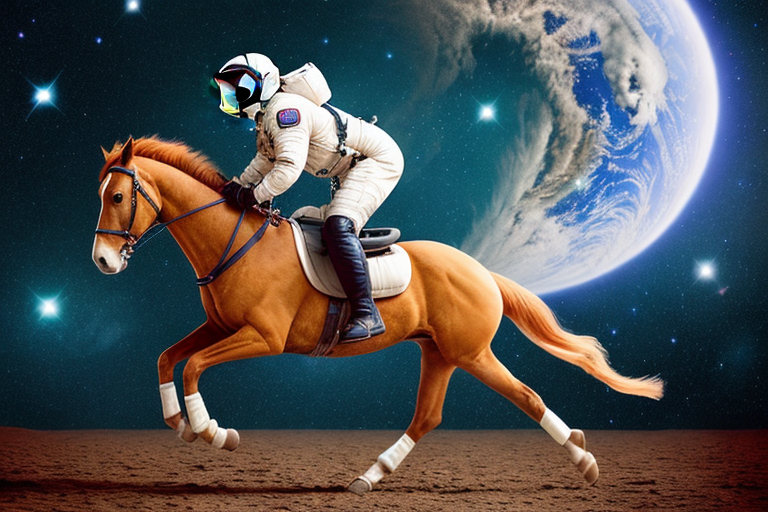

In [9]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(
    prompt          = prompt
    , generator     = torch.Generator("cuda:0").manual_seed(6)
    , width         = 768
    , height        = 512
).images[0]
display(image)

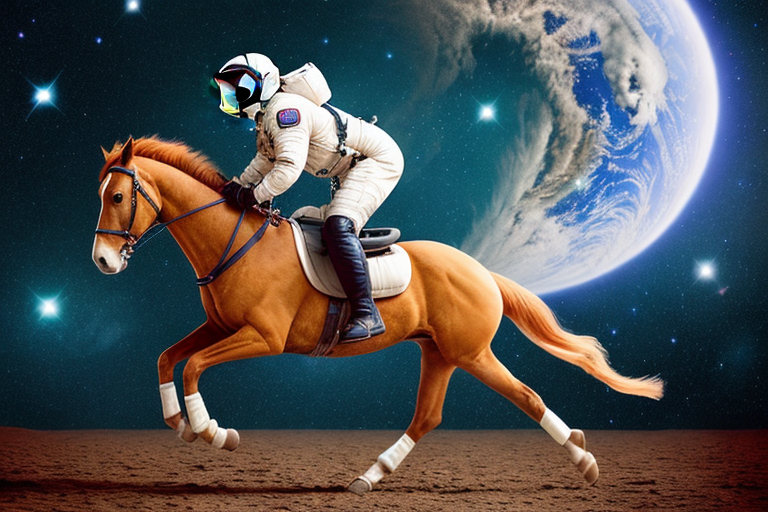

In [10]:
image

## Detectar o Background

Unused or unrecognized kwargs: padding.


torch.Size([352, 352])


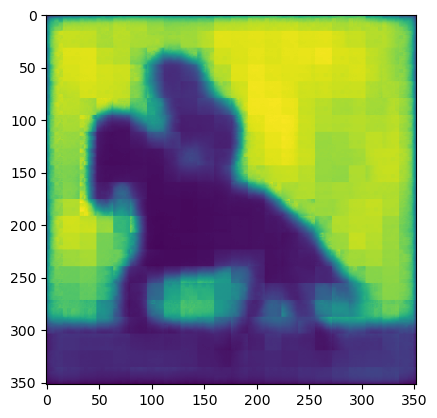

In [12]:
prompts = ['the background']
inputs = processor(
    text             = prompts
    , images         = [image] * len(prompts)
    , padding        = True
    , return_tensors = "pt"
)

with torch.no_grad():
    outputs = model_b(**inputs)

preds = outputs.logits

mask_data = torch.sigmoid(preds)[0]
print(mask_data.shape)
plt.imshow(mask_data)

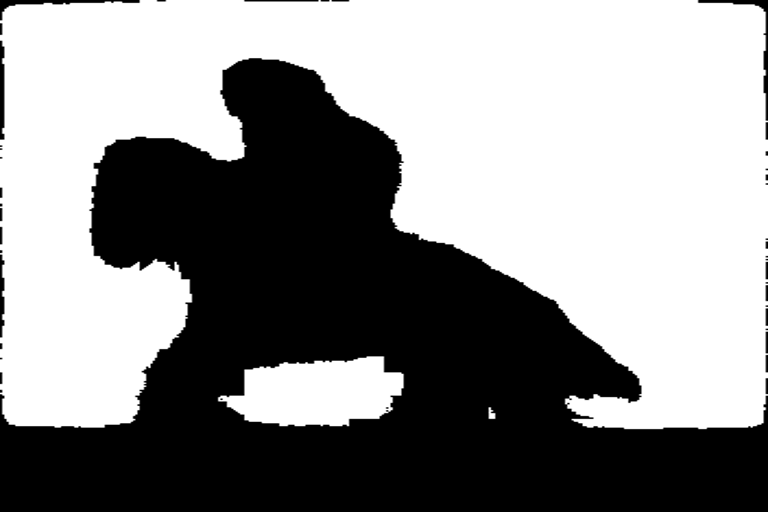

In [14]:
# Gerando imagem binária
mask_file_name = f"bg_mask.png"
plt.imsave(mask_file_name,mask_data) 
mask_data_cv = cv2.imread(mask_file_name) # -> (352, 352, 3)

def get_mask_img(mask_data):
    gray_image = cv2.cvtColor(mask_data,cv2.COLOR_BGR2GRAY)
    thresh, bw_image = cv2.threshold(gray_image,100,255,cv2.THRESH_BINARY)
    cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(bw_image)

bw_image = get_mask_img(mask_data=mask_data_cv)
bw_image = bw_image.resize((768,512))
bw_image

## Preenchimento de Áreas Ausentes - Trocando o Background

In [16]:
# Start a inpaint pipeline
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4"
    , torch_dtype = torch.float16
    , safety_checker = None
).to("cuda:0")
inpaint_pipe.scheduler = EulerDiscreteScheduler.from_config(inpaint_pipe.scheduler.config)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/45 [00:00<?, ?it/s]

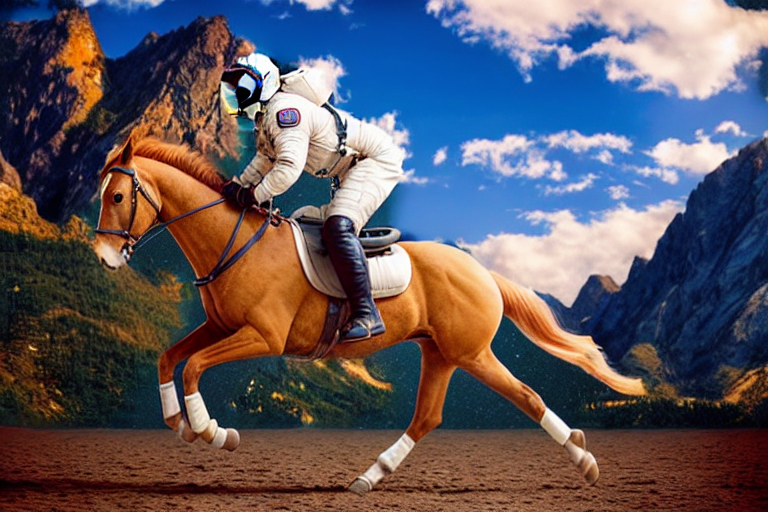

In [17]:
# Mudando o background
sd_prompt = "blue sky and mountains"
out_image = inpaint_pipe(
    prompt          = sd_prompt
    , image         = image
    , mask_image    = bw_image
    , strength      = 0.9
    , generator     = torch.Generator("cuda:0").manual_seed(7)
    # , guidance_scale = 7.5
    # , num_inference_steps = 50
    # , width = 768
    # , height = 512
).images[0]
out_image